**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Comparing neural networks and logistic regression in music classification* 

## Abstract

This project compares logistic regression and neural networks in music classification. The data is composed of 264-dimensional feature vectors which each represent one song classified in one of ten music genres. The dataset has qualities, such as class imbalance, high dimensionality and the small size of the training dataset, that pose difficulties for the classifying. The data is first analysed with principal components analysis and by other methods. After that, the data is classified first using a logistic regression model created with the SciKit-learn library and then with a deep neural network created with the Keras library. The unlabelled test data is also experimented on by clustering the data, but the results were poor by this method. The neural network yielded slightly better results than the logistic regression.

## 1. Introduction

Building a classifier nowadays is easier than ever, though building a good classifier is still a hard task despite the high availability of efficient tools created for this purpose. We wanted to investigate the performance of a minimally-tuned neural network in classification using out-of-the-box libraries and compare them to logistic regression. We chose Keras because of its popularity and documentation availability and SciKit-learn for the logistic regression implementation.

The data usually has many problems some of which cannot be known beforehand. Preprocessing and visualisation are necessary for building a proper model. However, data analysis is already quite ubiquitous and the need for better tools is ever-growing. Some people, who would benefit from machine learning and data analysis, might not even be aware of the current progress of the field nor the tools at all. If these people were made aware of the field it will overall benefit the society we live in. To this day, it still requires a data scientist/engineer to build the models because of the various bottlenecks present in data science. 

## 2. Data analysis

The supplied data contains 4363 labeled samples and 6544 unlabeled sample vectors. Every sample is a vector of length 264 which is composed of preprocessed properties of the original time-series data. There are 10 labels and the class distribution is unbalanced; almost half of the labeled samples have the same label which could lead to problems in classification. For example, we don't want the classifier to learn the class distribution of the training set because the class distribution might be completely different for the evaluation set. Some of the fields in the data contain almost identical values for the whole dataset which means these features cannot be used to differentiate samples. Some of the features may also be redundant and contribute nothing while having high variance amongst the dataset. 

In [147]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Load the data from file:

In [148]:
train_data = pd.read_csv('data/train_data.csv', header=None).values
labels = pd.read_csv('data/train_labels.csv', header=None).values

Plot the label distribution of the training data:

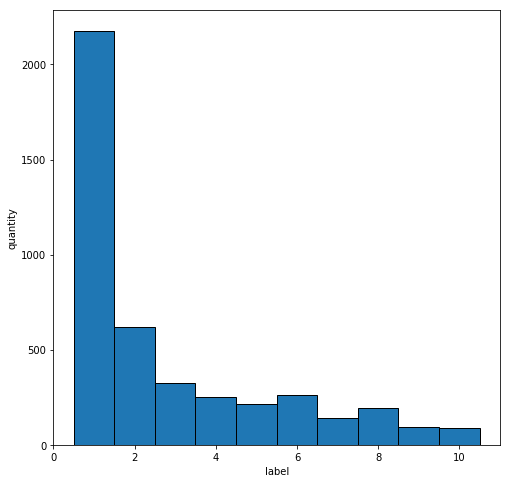

In [149]:
# plot label distribution in training data
plt.figure(1, figsize=(8, 8))
plt.hist(labels, range=(0.5,10.5), bins=10, ec='black')
plt.xlabel('label')
plt.ylabel('quantity')
plt.show()

Here the class imbalance can be seen clearly. It is also good to find out if the data is ordered to know if it needs to suffled before dividing it to training data and validation data. Here is a simple plot of the distribution of the labels in the csv file:

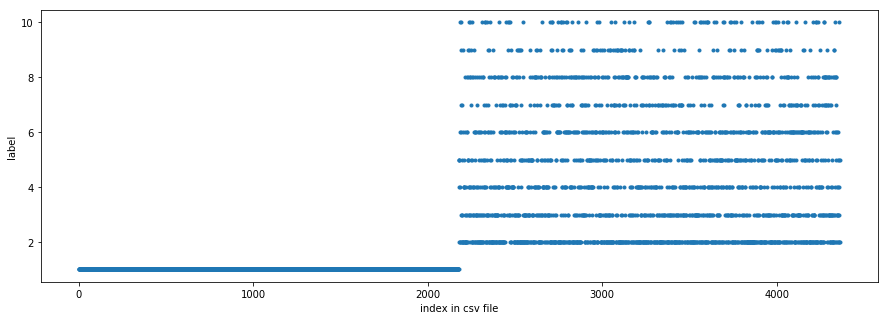

In [150]:
plt.figure(2, figsize=(15, 5))
plt.plot(labels, marker='.', linestyle = 'None')
plt.xlabel('index in csv file')
plt.ylabel('label')
plt.show()

We can see that Pop-rock songs are first in the file and the rest of the genres are distributed randomly after that.

### Principal components analysis

We can understand the dimensionality better by principal components analysis. Here is a class that is created on basis of the last Python exercise of this course:

In [151]:
class PCA:
    def __init__(self, data, d):
        self.data = data # raw data
        self.d = d # number of dimensions in the compressed data
        self.W_pca, self.eigvalues = self.compute_pca()

    def compute_pca(self):
        # Output: a d by D matrix W_pca, and all eigenvalues of Q

        N = self.data.shape[0]
        # step1: compute the sample cov. matrix Q
        Q = np.matmul(np.transpose(self.data), self.data ) / N
        #step2: compute the eigenvalues and eigenvectors
        w, v = np.linalg.eig(Q)
        #step3: Sort the eigenvectors by decreasing eigenvalues, choose the d largest eigenvalues, form W_pca
        ind = np.argsort(w)[::-1]
        W_pca = np.empty((self.d, self.data.shape[1]))
        eigvalues = w
        for i in range(self.d):
            W_pca[i] = v[:,ind[i]]
        
        return W_pca.real, eigvalues # discard imaginary part

    def plot_error(self,  max_d):
        x=range(1,max_d+1)
        errors=[sum(self.eigvalues[d:]) for d in x]
        plt.plot(x, errors)
        plt.xlabel('Number of principal components $d$')
        plt.ylabel('Reconstruction error $\mathcal{E}$')
        plt.title('Number of principal components vs the reconstruction error')
        plt.show()

    def plot_scatter(self):
        # get x for d=2
        X_2d = np.matmul(self.W_pca[:2,:],self.data[:,:,None])[:,:,0]
        plt.figure(1, figsize=(10, 10))   
        plt.scatter(X_2d[:2178,0], X_2d[:2178,1], 3, marker='o', color='blue')
        plt.scatter(X_2d[2178:,0], X_2d[2178:,1], 3, marker='x', color='red')
        plt.xlabel('First principal component')
        plt.ylabel('Second principal component')
        plt.show()

    
    def low_dim_data(self):
        new_data = np.ndarray((self.data.shape[0], self.d))
        for i in range(self.data.shape[0]):
            new_data[i] = np.matmul(self.W_pca, self.data[i])
        return new_data


To see roughly the ratio between the first, i.e. largest, principal components, the first five eigenvalues are printed and the reconstruction error is plotted for the first 30 principal components:

The first 5 principal component eigenvalues:
 [4.00299038e+12 7.40049027e+08 5.90703291e+08 2.63947178e+08
 1.78854204e+08]


C:\Users\Anssi\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Anssi\Anaconda3\lib\site-packages\numpy\core\numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


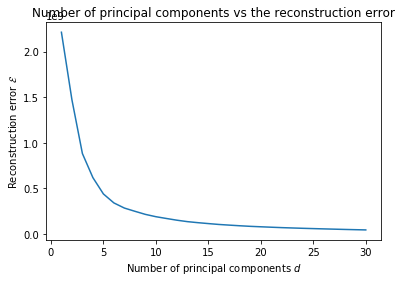

In [152]:
pca = PCA(train_data, 50)
print('The first 5 principal component eigenvalues:\n', pca.eigvalues[:5].real)
# plot the number of principal components vs the reconstruction error
pca.plot_error(30)

We see that the first component is about four orders of magnitude larger than the second. A scatterplot can be created where the first two components are used as axes. To try to understand how the labels are distributed in this space, we colour the Pop-rock genre as blue and the rest red:

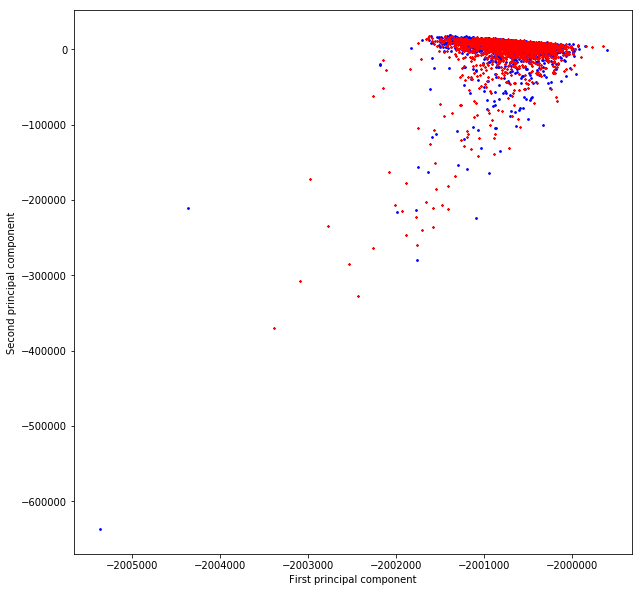

In [153]:
pca.plot_scatter()

This does not show clear division or clustering of the labels in this 2D space. The data can be scaled with a scikit-learn method and the PCA can be done again:

In [154]:
from sklearn import preprocessing
scaled_data = preprocessing.scale(train_data)

[69.46388432 26.52210249 14.06929455  9.70100502  6.915734  ]


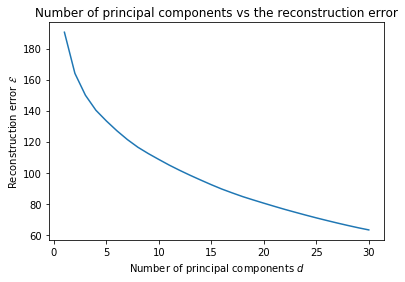

In [155]:
pca_scaled = PCA(scaled_data, 50)
print(pca_scaled.eigvalues[:5].real)
# plot the number of principal components vs the reconstruction error
pca_scaled.plot_error(30)

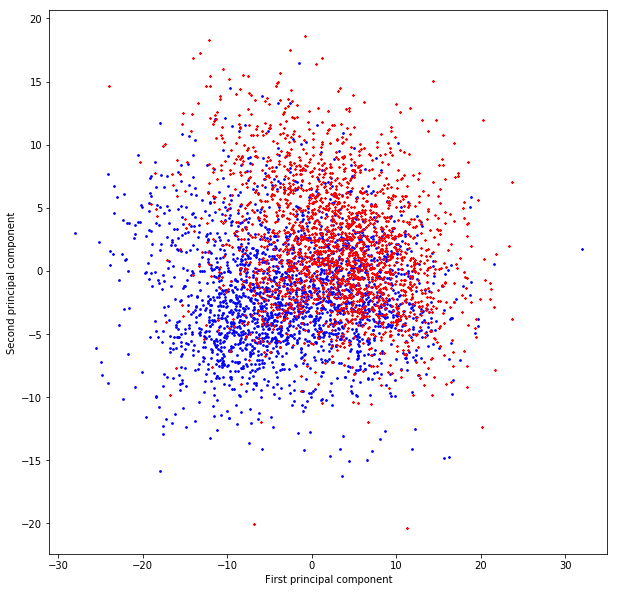

In [156]:
pca_scaled.plot_scatter()

From this scatterplot can be seen a slight shift in the direction of the 1st and 2nd principal components if we compare the Pop-rock class to the other classes. While the distrinction is quite clear there are still many datapoints which reside in both sides of the scatterplot indicating some similarities between different classes.

### Preprocessing of the data

We created a preprocessor class that does the scaling and other handling of the data, such as dividing it. We tried also balancing the data by generating new rows of the underrepresented classes. These new rows were copied instaces of the existing rows with some noise added to them.

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn import preprocessing

class Preprocessor:

    def __init__(self, path='data/', balance=True, mutation_rate=5e-2, scale=True):
        self.balance 		 = balance
        self.scale 			 = scale
        self.mutation_rate 	 = mutation_rate
        self.data_path 		 = path
        self.raw_data_labels = pd.read_csv(self.data_path + 'train_labels.csv', header=None)
        self.unique_labels	 = np.unique(self.raw_data_labels)
        self.raw_data 		 = self.load_raw_data('train_data.csv')
        self.test_data		 = self.load_raw_data('test_data.csv')

    def load_raw_data(self, file):
        data = pd.read_csv(self.data_path + file, header=None).values
        if self.scale:
            data = preprocessing.scale(data)
        return data

    def balance_raw_data(self, data, labels, save_bal_data, bal_data_path):
        distribution = {}
        raw = np.hstack((labels, data))
        for label in self.unique_labels:
            distribution[int(label)] = 0
        for label in labels:
            distribution[int(label)] += 1
        distmax = distribution[max(distribution, key=distribution.get)]
        amount = 0
        for key in distribution:
            amount += distmax - distribution[key]
        count = 0
        tmp = np.empty((0, 265))
        for label in self.unique_labels:
            auxiliary_rows = raw[raw[:, 0] == label]
            for _ in range(distmax - distribution[label]):
                to_add = auxiliary_rows[np.random.randint(auxiliary_rows.shape[0])]
                for elem in range(to_add.shape[0] - 1):
                    rnd = np.random.uniform(1 - self.mutation_rate, 1 + self.mutation_rate)
                    to_add[elem + 1] *= rnd
                count += 1
                if count % 1000 == 0:
                    print("Processed count: ", count, "/", amount)
                tmp = np.append(tmp, [to_add], axis=0)
        raw = np.vstack((raw, tmp))
        # optionally saves the data
        # boolean save_bal_data and save path is given to class method 'divided_data()'
        if save_bal_data:
            pd.DataFrame(raw).to_csv(bal_data_path)
        new_labels = raw[:, :1]
        new_features = raw[:, 1:]
        return new_features, new_labels

    def label_filter(self, row, label: int):
        #print(int(row[0])
        return row[0] == label

    # loads all feature vectors from training data and validation data for unsupervised learning
    # shape: (num_of_vectors, 264)
    def all_feature_vectors(self):
        pass

    # transforms the label data to vectors, for example: 2 => (0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
    # shape: 
    def transformed_labels(self, data):
        unique_labels = np.unique(self.raw_data_labels)
        labels = np.zeros((data.shape[0], unique_labels.shape[0]))
        for i in range(data.shape[0]):
            labels[i][int(data[i]) - 1] = 1
        assert labels.shape == (data.shape[0], unique_labels.shape[0])
        return labels

    # normalises columns to [0.0, 1.0]
    def normalize_data(self, data):
        transformed = data
        print(type(data))
        return transformed

    # divides training data according to ratio for training purposes: (training_data, training_labels), (testing_data, testing_labels)
    # shape: (ratio*4263, col), ((1 - ratio)*4363, col)
    # loads preprocessed data from file or preprocesses the data and optionally saves to file
    def divided_data(self, ratio=0.5, bal_data_path=None, load_bal_data=True, save_bal_data=False):
        # path to balanced data file is used for both loading and saving the file
        if not bal_data_path:
            # appends ratio in percentages to file name
            bal_data_path = self.data_path + 'bal_data_ratio_' + str(int(100*ratio)) + '.csv'

        raw = np.hstack((self.raw_data_labels, self.raw_data))
        np.random.shuffle(raw)
        num = int(ratio * raw.shape[0])
        training_data = raw[:num, 1:]
        training_labels = raw[:num, :1]

        # balance the data
        if (self.balance and not load_bal_data):
            training_data, training_labels = self.balance_raw_data(training_data, training_labels, save_bal_data, bal_data_path)

        # use old balanced data file
        if (self.balance and load_bal_data):
            raw = pd.read_csv(bal_data_path, header=None).values
            # pandas puts headers as first column and row
            training_labels = raw[1:, 1:2]
            training_data = raw[1:, 2:]

        testing_data = raw[num:, 1:]
        testing_labels = raw[num:, :1]
        return training_data, training_labels, testing_data, testing_labels

    # returns columns (1-168)
    # shape: (row, 168)
    def get_rhythm_patterns(self, data):
        return data[:,0:168]

    # return columns (169-216)
    # shape: (row, 48)
    def get_chroma(self, data):
        return data[:,168:216]

    # return columns 217-264
    # shape: (row, 48)
    def get_mfcc(self, data):
        return data[:,216:]

Although we tried balancing the data with this class, we noticed that balancing did not improve the results. For this reason, we do not use balanced data in the rest of this notebook. The next cell loads the data from the files.

In [158]:
# Create a preprocessor object and load the data
dl = Preprocessor(balance=False, scale=True)
x_train, y_train, x_test, y_test = dl.divided_data(ratio=0.8, load_bal_data=False)

## 3. Methods and experiments

We tried a few different methods including logistic regression, neural networks and clustering. The first two gave sufficient results while clustering gave a very poor accuracy. The poor performance of the clustering algorithms might be due to many reasons, such as imbalance and high dimensionality of the data. 

### SciKit-learn library

First we tried the logistic regression classifier from the SciKit library. We tried some different solvers and noticed the 'Stochastic Average Gradient'[3] solver to work best. Below, the logistic regression is fitted. This should take about half a minute with max_iter=500. More iterations do not seem to improve the result.

C:\Users\Anssi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


max_iter reached after 26 seconds
train score:  0.7853868194842407
test score:  0.6288659793814433
test log-loss:  1.3180495985667307


C:\Users\Anssi\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.4s finished


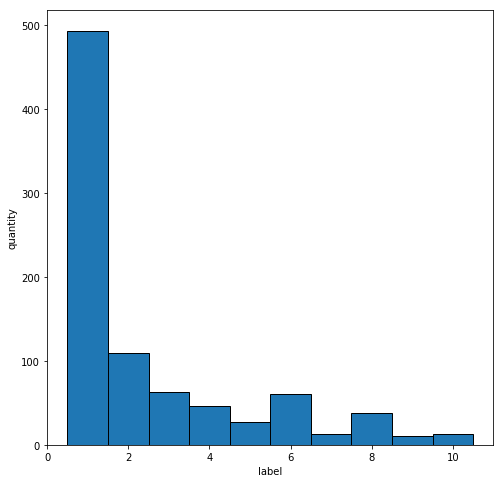

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# The classifier
clf = LogisticRegression(random_state=0, solver='saga',multi_class='multinomial', max_iter=500, verbose=1)

# Fit the data
model = clf.fit(x_train, y_train)

# Predict labels
prediction = model.predict(x_test)

# Plot the accuracy
print("train score: ", clf.score(x_train, y_train))
print("test score: ", clf.score(x_test, y_test))

# print logloss
clf_probs = clf.predict_proba(x_test)
score = log_loss(y_test, clf_probs)
print("test log-loss: ", score)

# plot label distribution of the prediction
plt.figure(1, figsize=(8, 8))
plt.hist(prediction, range=(0.5,10.5), bins=10, ec='black')
plt.xlabel('label')
plt.ylabel('quantity')
plt.show()

This gives an accuracy of about 65% on the test data and the label distribution looks about the same as the true distribution. We see that we can achieve a decent result with little work using the SciKit library. We tried also clustering with SciKit. The acc help method is from [4].

In [160]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

accuracy with kmeans:  0.23080449232179692


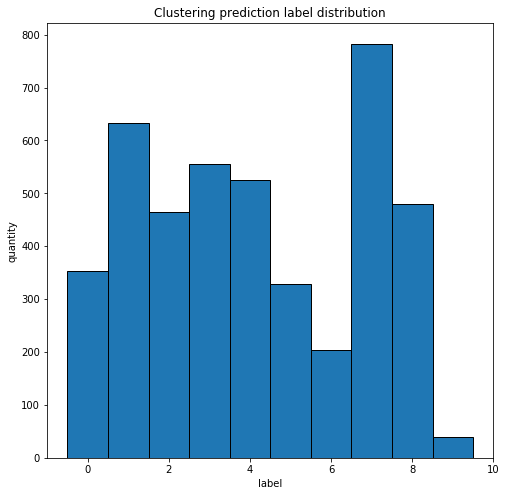

In [161]:
from sklearn.cluster import KMeans

x, y, notused, notused2 = dl.divided_data(ratio=1, load_bal_data=False)
y = y.reshape((len(y),))

# 10 clusters
n_clusters = 10

# Reduce dimensions with PCA:
#pca = PCA(x, 10)
#x = pca.low_dim_data()

kmeans = KMeans(n_clusters=n_clusters, n_init=20)

if __name__ == '__main__':
    y_pred = kmeans.fit_predict(x)

print("accuracy with kmeans: ", acc(y, y_pred))

# plot label distribution of the prediction
plt.figure(1, figsize=(8, 8))
plt.hist(y_pred, range=(-0.5,9.5), bins=10, ec='black')
plt.xlabel('label')
plt.ylabel('quantity')
plt.title('Clustering prediction label distribution')
plt.show()

We did not get any good results from our experiments with clustering. We tried changing various details, such as balancing the data (see the Preprocessing class) and using features with reduced dimensions by PCA. The best accuracy was 50% but this was achieved just by classing all songs in the Pop-rock class that is 50% of the training data. Therefore 50% is not a good result considering how it was attained. We discarded the method of clustering in our final model which we created with Keras.

### Deep network with Keras

We wanted to test how a modern neural network library performs. We first separated the data into thee distrinct categories according to the data description: rhythm, chroma and MFCC. We then put each of these in separate inputs and made a shallow network to interpret the data. Afterward we combined the results into a single layer which was followed by a deep layer composition. The hyperparameters were chosen mainly by testing out different ones and looking for the best ones. Last layer uses softmax activation explicitly since we wanted to use the same results for both competitions. Log-loss values were the direct values from the last layer and labels where chosen by the largest element in the 10-long label vector.

In [162]:
# Keras Input layers need the labels as vectors of ten, e.g. 2 = (0, 1, 0, 0, 0, 0, 0, 0, 0, 0)
y_train_net = dl.transformed_labels(y_train)
y_test_net = dl.transformed_labels(y_test)

The below cells require installing Keras. Training of the model might take some time.

Train on 3490 samples, validate on 873 samples
Epoch 1/300
3490/3490 [==============================] - 3s 732us/step - loss: 2.1610 - acc: 0.2705 - val_loss: 1.7238 - val_acc: 0.5052
Epoch 2/300
3490/3490 [==============================] - 0s 42us/step - loss: 1.7908 - acc: 0.4745 - val_loss: 1.4642 - val_acc: 0.5682
Epoch 3/300
3490/3490 [==============================] - 0s 42us/step - loss: 1.5932 - acc: 0.5123 - val_loss: 1.3659 - val_acc: 0.5876
Epoch 4/300
3490/3490 [==============================] - 0s 43us/step - loss: 1.5033 - acc: 0.5372 - val_loss: 1.3435 - val_acc: 0.6025
Epoch 5/300
3490/3490 [==============================] - 0s 43us/step - loss: 1.4615 - acc: 0.5473 - val_loss: 1.2865 - val_acc: 0.6048
Epoch 6/300
3490/3490 [==============================] - 0s 41us/step - loss: 1.4273 - acc: 0.5590 - val_loss: 1.2760 - val_acc: 0.6197
Epoch 7/300
3490/3490 [==============================] - 0s 42us/step - loss: 1.3648 - acc: 0.5782 - val_loss: 1.2588 - val_acc: 0.6197


3490/3490 [==============================] - 0s 43us/step - loss: 0.9792 - acc: 0.6963 - val_loss: 1.1662 - val_acc: 0.6644
Epoch 61/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.9860 - acc: 0.6946 - val_loss: 1.1776 - val_acc: 0.6564
Epoch 62/300
3490/3490 [==============================] - 0s 42us/step - loss: 0.9633 - acc: 0.6946 - val_loss: 1.1681 - val_acc: 0.6598
Epoch 63/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.9551 - acc: 0.6954 - val_loss: 1.1644 - val_acc: 0.6564
Epoch 64/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.9768 - acc: 0.7011 - val_loss: 1.1683 - val_acc: 0.6644
Epoch 65/300
3490/3490 [==============================] - 0s 43us/step - loss: 0.9738 - acc: 0.6971 - val_loss: 1.1627 - val_acc: 0.6598
Epoch 66/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.9491 - acc: 0.7037 - val_loss: 1.1756 - val_acc: 0.6621
Epoch 67/300
3490/3490 [==============================

Epoch 120/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.8220 - acc: 0.7355 - val_loss: 1.2197 - val_acc: 0.6598
Epoch 121/300
3490/3490 [==============================] - 0s 42us/step - loss: 0.8124 - acc: 0.7384 - val_loss: 1.2243 - val_acc: 0.6586
Epoch 122/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.7973 - acc: 0.7533 - val_loss: 1.2349 - val_acc: 0.6701
Epoch 123/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.8184 - acc: 0.7470 - val_loss: 1.2194 - val_acc: 0.6667
Epoch 124/300
3490/3490 [==============================] - 0s 42us/step - loss: 0.8076 - acc: 0.7524 - val_loss: 1.2185 - val_acc: 0.6598
Epoch 125/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.8087 - acc: 0.7481 - val_loss: 1.2130 - val_acc: 0.6621
Epoch 126/300
3490/3490 [==============================] - 0s 41us/step - loss: 0.8338 - acc: 0.7447 - val_loss: 1.2135 - val_acc: 0.6609
Epoch 127/300
3490/3490 [=========

3490/3490 [==============================] - 0s 45us/step - loss: 0.7245 - acc: 0.7797 - val_loss: 1.2603 - val_acc: 0.6575
Epoch 180/300
3490/3490 [==============================] - 0s 45us/step - loss: 0.7382 - acc: 0.7728 - val_loss: 1.2760 - val_acc: 0.6621
Epoch 181/300
3490/3490 [==============================] - 0s 44us/step - loss: 0.7063 - acc: 0.7845 - val_loss: 1.2612 - val_acc: 0.6483
Epoch 182/300
3490/3490 [==============================] - 0s 46us/step - loss: 0.7188 - acc: 0.7779 - val_loss: 1.2790 - val_acc: 0.6541
Epoch 183/300
3490/3490 [==============================] - 0s 45us/step - loss: 0.7489 - acc: 0.7653 - val_loss: 1.2772 - val_acc: 0.6575
Epoch 184/300
3490/3490 [==============================] - 0s 44us/step - loss: 0.7145 - acc: 0.7808 - val_loss: 1.2739 - val_acc: 0.6552
Epoch 185/300
3490/3490 [==============================] - 0s 43us/step - loss: 0.7223 - acc: 0.7777 - val_loss: 1.2623 - val_acc: 0.6564
Epoch 186/300
3490/3490 [=======================

3490/3490 [==============================] - 0s 47us/step - loss: 0.6686 - acc: 0.7960 - val_loss: 1.3189 - val_acc: 0.6495
Epoch 239/300
3490/3490 [==============================] - 0s 49us/step - loss: 0.6620 - acc: 0.7888 - val_loss: 1.3131 - val_acc: 0.6506
Epoch 240/300
3490/3490 [==============================] - 0s 58us/step - loss: 0.6539 - acc: 0.7917 - val_loss: 1.3137 - val_acc: 0.6518
Epoch 241/300
3490/3490 [==============================] - 0s 57us/step - loss: 0.6379 - acc: 0.7963 - val_loss: 1.3287 - val_acc: 0.6483
Epoch 242/300
3490/3490 [==============================] - 0s 57us/step - loss: 0.6475 - acc: 0.7954 - val_loss: 1.3386 - val_acc: 0.6460
Epoch 243/300
3490/3490 [==============================] - 0s 52us/step - loss: 0.6502 - acc: 0.7951 - val_loss: 1.3459 - val_acc: 0.6460
Epoch 244/300
3490/3490 [==============================] - 0s 48us/step - loss: 0.6430 - acc: 0.7977 - val_loss: 1.3219 - val_acc: 0.6541
Epoch 245/300
3490/3490 [=======================

3490/3490 [==============================] - 0s 46us/step - loss: 0.6244 - acc: 0.8026 - val_loss: 1.3693 - val_acc: 0.6506
Epoch 298/300
3490/3490 [==============================] - 0s 43us/step - loss: 0.6035 - acc: 0.8115 - val_loss: 1.3751 - val_acc: 0.6495
Epoch 299/300
3490/3490 [==============================] - 0s 45us/step - loss: 0.6054 - acc: 0.8117 - val_loss: 1.3557 - val_acc: 0.6426
Epoch 300/300
3490/3490 [==============================] - 0s 45us/step - loss: 0.6192 - acc: 0.8126 - val_loss: 1.3595 - val_acc: 0.6541


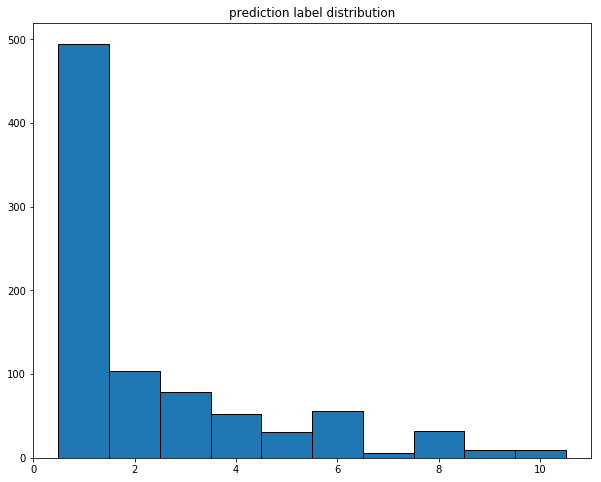

In [163]:
import keras
from keras.layers import Input, LSTM, concatenate, Dense, Dropout, BatchNormalization, GRU, GaussianNoise
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.regularizers import l1_l2

rhythm_input = Input(shape=(168,)) # timesteps, timestep dimension
chroma_input = Input(shape=(48,)) # timesteps, timestep dimension
mfcc_input 	 = Input(shape=(48,)) # timesteps, timestep dimension

rhythm  = Dense(168, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(rhythm_input)
rhythm  = Dropout(rate=0.3)(rhythm)
rhythm  = Dense(42, activation='softmax', kernel_regularizer=l1_l2(1e-6, 2e-6))(rhythm)
rhythm  = Dropout(rate=0.4)(rhythm)

chroma  = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(chroma_input)
chroma  = Dropout(rate=0.3)(chroma)
chroma  = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(chroma)
chroma  = Dropout(rate=0.4)(chroma)

mfcc    = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(mfcc_input)
mfcc    = Dropout(rate=0.3)(mfcc)
mfcc    = Dense(48, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(mfcc)
mfcc    = Dropout(rate=0.4)(mfcc)

classifier 	 = concatenate([rhythm, chroma, mfcc], axis=-1)

for rate in range(3):
    classifier = Dense(120, activation='tanh', kernel_regularizer=l1_l2(1e-6, 1e-6))(classifier)
    classifier = Dropout(rate=0.3)(classifier)

classifier = Dense(10, activation='softmax', kernel_regularizer=l1_l2(1e-7, 1e-6))(classifier)

input_data = [
    x_train[:, :168],
    x_train[:, 168:216],
    x_train[:, 216:]
]

validation_data = [
    x_test[:, :168],
    x_test[:, 168:216],
    x_test[:, 216:]
]

tensorboardCB = keras.callbacks.TensorBoard(log_dir='./Graph', 
                                          histogram_freq=1,  
                                          write_graph=True, 
                                          write_images=True)

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=True)
sgd = SGD(momentum=0.1, nesterov=True)

model = Model(inputs=[rhythm_input, chroma_input, mfcc_input], outputs=classifier)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(input_data, y_train_net, 
                validation_data=(validation_data, y_test_net), 
                batch_size=256, 
                epochs=300)

# predict
prediction_net = model.predict(validation_data)
# convert probabilities into labels
y_classes = prediction_net.argmax(axis=-1) 
# shift classes from 0-9 to 1-10
y_classes = np.subtract(y_classes, [-1]*len(y_classes)) 
# plot the label distribution
plt.figure(2, figsize=(10, 8))
plt.title("prediction label distribution")
plt.hist(y_classes, range=(0.5,10.5), bins=10, ec='black')
plt.show()

## 4. Results

From the confusion matrix we can see which labels are confused as each other. The confusion matrix code is from [5].

In [164]:
from sklearn.metrics import confusion_matrix
conf_m = confusion_matrix(y_test, prediction)

Confusion matrix, without normalization
Normalized confusion matrix


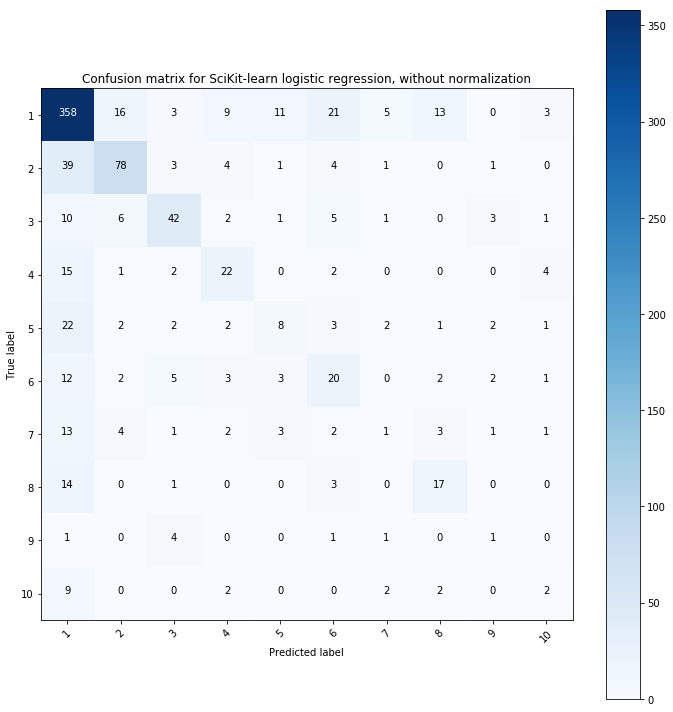

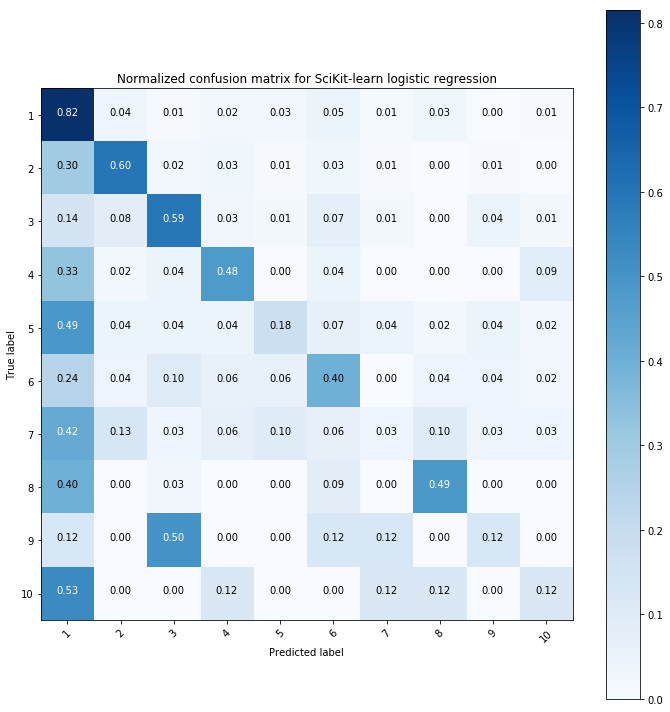

In [165]:
# print(__doc__)

import itertools
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

def plot_confusion_matrix(cm, classes=['1','2','3','4','5','6','7','8','9','10'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)
# np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m,
                      title='Confusion matrix for SciKit-learn logistic regression, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m, normalize=True,
                      title='Normalized confusion matrix for SciKit-learn logistic regression')

plt.show()

The confusion matrix produced by the regression based classifier indicates that the regression has trouble separating class 1 from other classes. Class 1 was by large the most abundant sample class available which explains why the simple regression classifies too many samples to class 1.

The same problem can be seen with the network model. The neural network based implementation has a similar confusion matrix and it also has some problem separating the rest of the classes from class 1. The classes that were most underrepresented were difficult for both of the models, mostly the classes 7 and 10. 

Confusion matrix, without normalization
Normalized confusion matrix


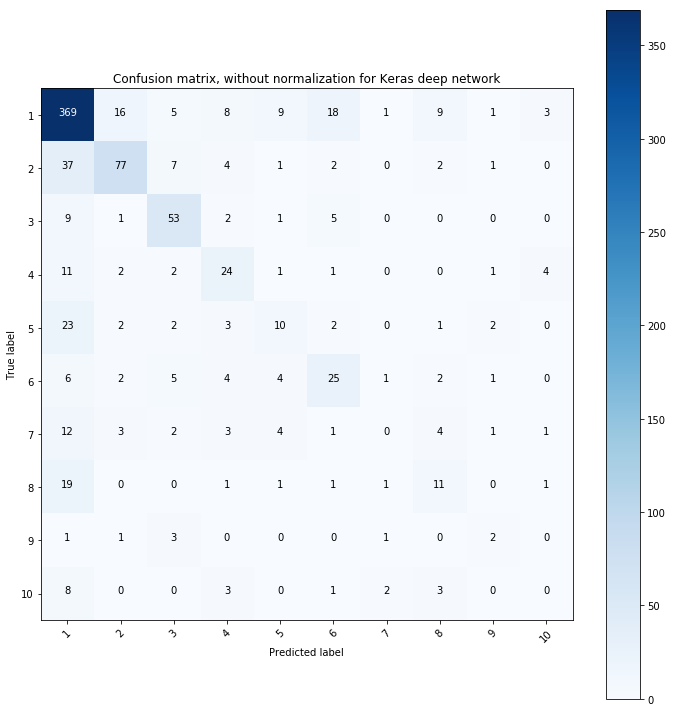

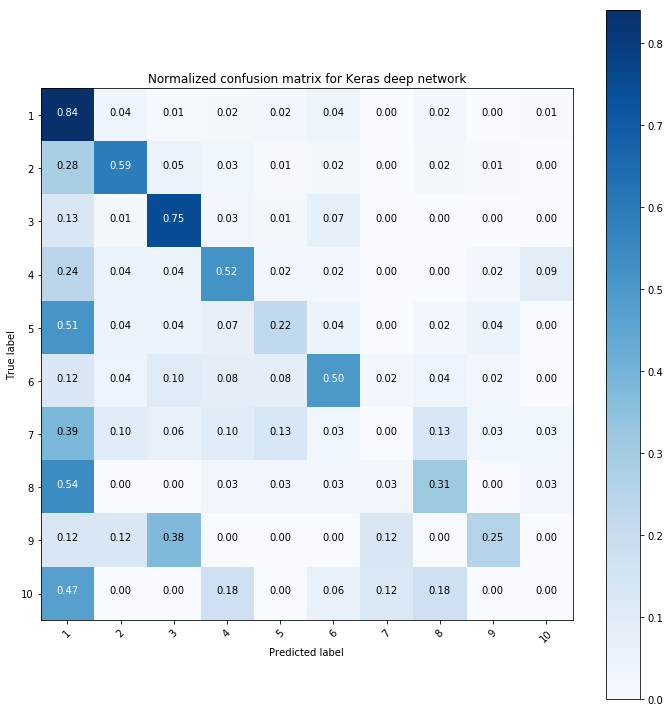

In [166]:
# plot confusion matrix for the Keras deep network model
conf_m = confusion_matrix(y_test, y_classes)
# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m,
                      title='Confusion matrix, without normalization for Keras deep network')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(conf_m, normalize=True,
                      title='Normalized confusion matrix for Keras deep network')

plt.show()

The log loss for the logistic regression model was about 1.2 and for the neural network about 1.4 when calculated on the validation data. However, the result in Kaggle was about 0.2, which we assume is because of a slightly different definition of the log loss calculation.

## 5. Discussion/Conclusions

The neural network yielded similar results to the logistic regression with slightly higher performance. Since we wanted to use the same network for both competitions we were not able to tailor the model for the individual competitions which may affect the overall performance of the model. First problem we ran into when designing the network were that the network learned the class distribution of the training dataset instead of generalizing based on the features. Unbalanced data remains a non-trivial problem to be solved.

It might be feasible to build a pipeline for the classification: since the classes are quite inbalanced (for example, class 1 being almost half of the samples) we could build a classifier that tells us whether a sample belongs to class 1 or not. Latter result makes the model advance in its pipeline to a classifier that classifies a somewhat evenly distributed dataset next (for example, classes 4-8 in the next classifier). Then it could advance to a stage where it checks whether a sample belongs to class 2 or to set of classes (3, 9, 10). Latter result would then differentiate between class 3 and set (9, 10) and then at the last stage it would identify whether the sample belongs to class 9 or class 10.

Class inbalance could also be handled with creating dummy data. We tried duplicating the low-count samples and sometimes even mutating them to make them distinct from the original data but this kind of preprocessing did not give us better results. A generative adversarial network may yield sufficient results for this purpose but we did not have the time to test GANs [2].

The neural net performed quite well (64% accuracy) as did the logistic regression (62% accuracy). The difference was a little larger when we returned the results to Kaggle, i.e. when the models were tested with completely new data. This suggests that the neural net was able to generalize better and not overfit to the training data as much as the logistic regression model did. We were unable to achieve results over 70% with the validation data (checking was done during the training). We tried different optimizers and went with Adam since it can be expected to converge faster than other optimizers [1].

## 6. References

 [1] https://arxiv.org/abs/1412.6980v8
 
 [2] https://arxiv.org/abs/1406.2661
 
 [3] https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-defintions
 
 [4] https://github.com/Tony607/Keras_Deep_Clustering
 
 [5] http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
 